<a href="https://colab.research.google.com/github/TahaHasan21/Medical_ChatBot/blob/main/Medical_chatBot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
import numpy as np
import pandas as pd
import math
from sklearn.model_selection import train_test_split,cross_val_score
import math
import operator
import pickle
import re
from nltk.stem import WordNetLemmatizer
import numpy as np
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer
from statistics import mean
from nltk.corpus import wordnet
import requests
from bs4 import BeautifulSoup
from itertools import combinations
from time import time
from collections import Counter
import operator
import warnings
warnings.simplefilter("ignore")

In [ ]:
pip install --upgrade pip

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 10.3 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 23.1.2
    Uninstalling pip-23.1.2:
      Successfully uninstalled pip-23.1.2


In [ ]:
df=pd.read_csv("/content/Disease-Detection-based-on-Symptoms/Dataset/dis_sym_dataset_norm.csv")
documentname_list=list(df['label_dis'])
df=df.iloc[:,1:]
columns_name=list(df.columns)
documentname_list=list(documentname_list)

N=len(df)
M=len(columns_name)
idf={}
for col in columns_name:
  temp=np.count_nonzero(df[col])
  idf[col]=np.log(N/temp)
tf={}
for i in range(N):
  for col in columns_name:
    key=(documentname_list[i],col)
    tf[key]=df.loc[i,col]
tf_idf={}
for i in range(N):
  for col in columns_name:
    key=(documentname_list[i],col)
    tf_idf[key]=float(idf[col])*float(tf[key])

D = np.zeros((N, M),dtype='float32')
for i in tf_idf:
    sym = columns_name.index(i[1])
    dis=documentname_list.index(i[0])
    D[dis][sym] = tf_idf[i]

def cosine_dot(a, b):
    if np.linalg.norm(a) == 0 or np.linalg.norm(b) == 0:
        return 0
    else:
        temp = np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))
        return temp


def convert_tolowercase(data):
    return data.lower()


def regextokenizer_func(data):
    tokenizer = RegexpTokenizer(r'\w+')
    data = tokenizer.tokenize(data)
    return data


def gen_vector(tokens):
    Q = np.zeros(M)
    counter = Counter(tokens)
    query_weights = {}
    for token in np.unique(tokens):
        tf = counter[token]
        try:
          idf_temp=idf[token]
        except:
          pass
        try:
            ind = columns_name.index(token)
            Q[ind] = tf*idf_temp
        except:
            pass
    return Q


def tf_idf_score(k, query):
    query_weights = {}
    for key in tf_idf:
        if key[1] in query:
            try:
                query_weights[key[0]] += tf_idf[key]
            except:
                query_weights[key[0]] = tf_idf[key]
    query_weights = sorted(query_weights.items(), key=lambda x: x[1], reverse=True)

    l = []
    for i in query_weights[:k]:
        l.append(i)
    return l


def cosine_similarity(k, query):
    d_cosines = []
    query_vector = gen_vector(query)
    for d in D:
        d_cosines.append(cosine_dot(query_vector, d))
    out = np.array(d_cosines).argsort()[-k:][::-1]

    final_display_disease={}
    for lt in set(out):
      final_display_disease[lt] = float(d_cosines[lt])
    return final_display_disease

In [ ]:

def synonyms(term):
    synonyms = []
    response = requests.get('https://www.thesaurus.com/browse/{}'.format(term))
    soup = BeautifulSoup(response.content,  "html.parser")
    try:
        container=soup.find('section', {'class': 'MainContentContainer'})
        row=container.find('div',{'class':'css-191l5o0-ClassicContentCard'})
        row = row.find_all('li')
        for x in row:
            synonyms.append(x.get_text())
    except:
        None
    for syn in wordnet.synsets(term):
        synonyms+=syn.lemma_names()
    return set(synonyms)

In [ ]:
splitter = RegexpTokenizer(r'\w+')
stop_words = stopwords.words('english')
lemmatizer = WordNetLemmatizer()

In [ ]:
df_comb = pd.read_csv(r"/content/Disease-Detection-based-on-Symptoms/Dataset/dis_sym_dataset_comb.csv") # Disease combination
df_norm = pd.read_csv(r"/content/Disease-Detection-based-on-Symptoms/Dataset/dis_sym_dataset_norm.csv") # Individual Disease
Y = df_norm.iloc[:, 0:1]
X = df_norm.iloc[:, 1:]
dataset_symptoms = list(X.columns)
diseases = list(set(Y['label_dis']))
diseases.sort()

In [ ]:
import nltk
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
print("Hello! Welcome to our Virtual-Chatbot")
user_symptoms = str(input("\nEnter symptoms:\n")).lower().split(',')
processed_user_symptoms=[]
for sym in user_symptoms:
    sym=sym.strip()
    sym=sym.replace('-',' ')
    sym=sym.replace("'",'')
    sym = ' '.join([lemmatizer.lemmatize(word) for word in splitter.tokenize(sym)])
    processed_user_symptoms.append(sym)

Hello! Welcome to our Virtual-Chatbot

Enter symptoms:
Fever, cough


In [ ]:
user_symptoms = []
for user_sym in processed_user_symptoms:
    user_sym = user_sym.split()
    str_sym = set()
    for comb in range(1, len(user_sym)+1):
        for subset in combinations(user_sym, comb):
            subset=' '.join(subset)
            subset = synonyms(subset)
            str_sym.update(subset)
    str_sym.add(' '.join(user_sym))
    user_symptoms.append(' '.join(str_sym).replace('_',' '))
print("Analysing the Symptoms entered")
print(user_symptoms)

Analysing the Symptoms entered
['pyrexia febricity fever febrility feverishness', 'cough coughing']


In [ ]:
found_symptoms = set()
for idx, data_sym in enumerate(dataset_symptoms):
    data_sym_split=data_sym.split()
    for user_sym in user_symptoms:
        count=0
        for symp in data_sym_split:
            if symp in user_sym.split():
                count+=1
        if count/len(data_sym_split)>0.5:
            found_symptoms.add(data_sym)
found_symptoms = list(found_symptoms)

In [ ]:
print("Matching symptoms from the data entered")
for idx, symp in enumerate(found_symptoms):
    print(idx,":",symp)

select_list = input("\n Hello User! Select more relevant symptoms \n").split()

dis_list = set()
final_symp = []
counter_list = []
for idx in select_list:
    symp=found_symptoms[int(idx)]
    final_symp.append(symp)
    dis_list.update(set(df_norm[df_norm[symp]==1]['label_dis']))

for dis in dis_list:
    row = df_norm.loc[df_norm['label_dis'] == dis].values.tolist()
    row[0].pop(0)
    for idx,val in enumerate(row[0]):
        if val!=0 and dataset_symptoms[idx] not in final_symp:
            counter_list.append(dataset_symptoms[idx])

dict_symp = dict(Counter(counter_list))
dict_symp_tup = sorted(dict_symp.items(), key=operator.itemgetter(1),reverse=True)

Matching symptoms from the data entered
0 : fever
1 : coughing

 Hello User! Select more relevant symptoms 
0


In [ ]:
found_symptoms=[]
count=0
for tup in dict_symp_tup:
    count+=1
    found_symptoms.append(tup[0])
    if count%5==0 or count==len(dict_symp_tup):
        print("\nCommon symptoms:")
        for idx,ele in enumerate(found_symptoms):
            print(idx,":",ele)
        select_list = input("Do you have have of these symptoms? If Yes, enter the indices (space-separated), 'no' to stop, '-1' to skip:\n").lower().split();
        if select_list[0]=='no':
            break
        if select_list[0]=='-1':
            found_symptoms = []
            continue
        for idx in select_list:
            final_symp.append(found_symptoms[int(idx)])
        found_symptoms = []


Common symptoms:
0 : headache
1 : testicular pain
2 : vomiting
3 : barky cough
4 : sore throat


In [ ]:
k = 10

print("Final list of Symptoms used for prediction are : ")
for val in final_symp:
    print(val)

Final list of Symptoms used for prediction are : 
fever
headache


In [ ]:
pip install googlesearch-python

In [ ]:
import re
import warnings
warnings.filterwarnings("ignore")
import requests
from bs4 import BeautifulSoup

# Take input a disease and return the content of wikipedia's infobox for that specific disease



try:
    from googlesearch import search
except ImportError:
    print("No module named 'google' found")

def diseaseDetail(term):
    diseases=[term]
    ret=term+"\n"
    for dis in diseases:
        # search "disease wilipedia" on google
        query = dis+' wikipedia'
        for sr in search(query, num_results=10):
            # open wikipedia link
            match=re.search(r'wikipedia',sr)
            filled = 0
            if match:
                wiki = requests.get(sr,verify=False)
                soup = BeautifulSoup(wiki.content, 'html5lib')
                # Fetch HTML code for 'infobox'
                info_table = soup.find("table", {"class":"infobox"})
                if info_table is not None:
                    # Preprocess contents of infobox
                    for row in info_table.find_all("tr"):
                        data=row.find("th",{"scope":"row"})
                        if data is not None:
                            symptom=str(row.find("td"))
                            symptom = symptom.replace('.','')
                            symptom = symptom.replace(';',',')
                            symptom = symptom.replace('<b>','<b> \n')
                            symptom=re.sub(r'<a.*?>','',symptom) # Remove hyperlink
                            symptom=re.sub(r'</a>','',symptom) # Remove hyperlink
                            symptom=re.sub(r'<[^<]+?>',' ',symptom) # All the tags
                            symptom=re.sub(r'\[.*\]','',symptom) # Remove citation text
                            symptom=symptom.replace("&gt",">")
                            ret+=data.get_text()+" - "+symptom+"\n"
#                            print(data.get_text(),"-",symptom)
                            filled = 1
                if filled:
                    break
    return ret

In [ ]:
topk1=tf_idf_score(k,final_symp)
topk2=cosine_similarity(k,final_symp)
print(f"\nTop {k} diseases predicted based on TF_IDF Matching :\n")
i = 0
topk1_index_mapping = {}
for key, score in topk1:
  print(f"{i}. Disease : {key} \t Score : {round(score, 2)}")
  topk1_index_mapping[i] = key
  i += 1

select = input("\nTo enter more details about the disease? Enter index of disease or '-1' to discontinue:\n")
if select!='-1':
    dis=topk1_index_mapping[int(select)]
    print()
    print(diseaseDetail(dis))


Top 10 diseases predicted based on TF_IDF Matching :

0. Disease : Acute encephalitis syndrome 	 Score : 3.24
1. Disease : Aseptic meningitis 	 Score : 3.24
2. Disease : Black Death 	 Score : 3.24
3. Disease : Bubonic plague 	 Score : 3.24
4. Disease : Chagas disease 	 Score : 3.24
5. Disease : Chickenpox 	 Score : 3.24
6. Disease : Crimean Congo haemorrhagic fever (CCHF) 	 Score : 3.24
7. Disease : Dengue 	 Score : 3.24
8. Disease : Ebola 	 Score : 3.24
9. Disease : Influenza 	 Score : 3.24

To enter more details about the disease? Enter index of disease or '-1' to discontinue:
-1


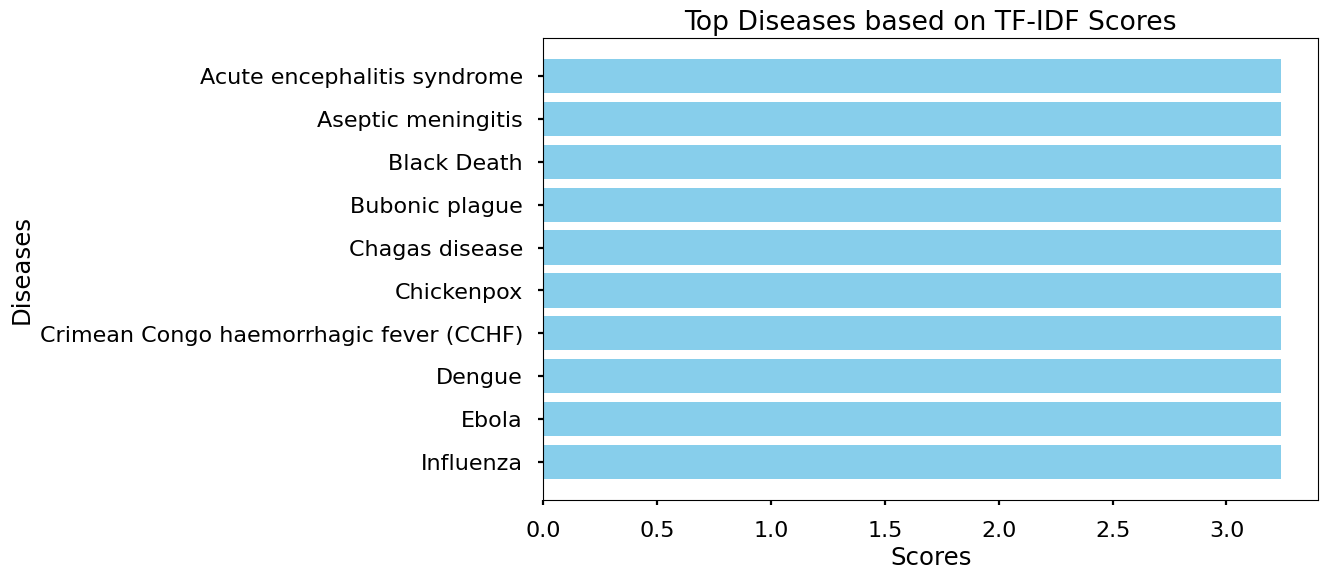

In [ ]:
import matplotlib.pyplot as plt

# Function to plot top diseases based on scores
def plot_top_diseases(top_diseases, title):
    diseases = []
    scores = []
    for disease, score in top_diseases:
        diseases.append(disease)
        scores.append(score)

    plt.figure(figsize=(10, 6))
    plt.barh(diseases, scores, color='skyblue')
    plt.xlabel('Scores')
    plt.ylabel('Diseases')
    plt.title(title)
    plt.gca().invert_yaxis()  # Invert y-axis to have highest score at the top
    plt.show()

# Plot top diseases based on TF-IDF scores
plot_top_diseases(topk1, 'Top Diseases based on TF-IDF Scores')


In [ ]:
print(f"Top {k} disease based on Cosine Similarity Matching :\n ")
topk2_sorted = dict(sorted(topk2.items(), key=lambda kv: kv[1], reverse=True))
j = 0
topk2_index_mapping = {}
for key in topk2_sorted:
  print(f"{j}. Disease : {diseases[key]} \t Score : {round(topk2_sorted[key], 2)}")
  topk2_index_mapping[j] = diseases[key]
  j += 1


select = input("\nMore details about the disease? Enter index of disease or '-1' to discontinue and close the system:\n")
if select!='-1':
    dis=topk2_index_mapping[int(select)]
    print()
    print(diseaseDetail(dis))

Top 10 disease based on Cosine Similarity Matching :
 
0. Disease : Rocky Mountain spotted fever 	 Score : 1.0
1. Disease : Leptospirosis 	 Score : 0.76
2. Disease : Rift Valley fever 	 Score : 0.76
3. Disease : Malaria 	 Score : 0.66
4. Disease : Black Death 	 Score : 0.6
5. Disease : Scrub Typhus 	 Score : 0.56
6. Disease : Paratyphoid fever 	 Score : 0.5
7. Disease : Chagas disease 	 Score : 0.46
8. Disease : Nipah virus infection 	 Score : 0.45
9. Disease : Legionellosis 	 Score : 0.45

More details about the disease? Enter index of disease or '-1' to discontinue and close the system:
8

Nipah virus infection
Disease -  Nipah virus 
Date -  2018, 2021, 2023 
Fatality rate -  894% (2018) 



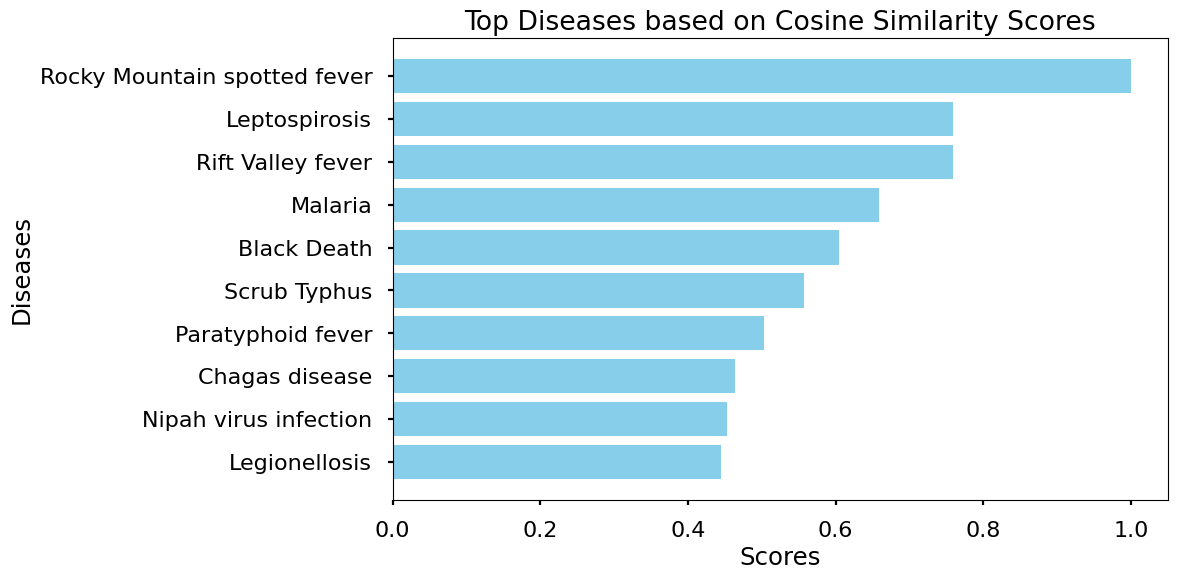

In [ ]:
import matplotlib.pyplot as plt

# Function to plot top diseases based on scores
def plot_top_diseases(top_diseases, title):
    diseases = []
    scores = []
    for disease, score in top_diseases:
        diseases.append(disease)
        scores.append(score)

    plt.figure(figsize=(10, 6))
    plt.barh(diseases, scores, color='skyblue')
    plt.xlabel('Scores')
    plt.ylabel('Diseases')
    plt.title(title)
    plt.gca().invert_yaxis()  # Invert y-axis to have highest score at the top
    plt.show()

# Plot top diseases based on Cosine Similarity scores
cosine_similarity_scores = [(diseases[index], score) for index, score in topk2_sorted.items()]
plot_top_diseases(cosine_similarity_scores, 'Top Diseases based on Cosine Similarity Scores')


In [ ]:
# all necessary imports
import warnings
from decimal import Decimal
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
# ignore warnings generated due to usage of old version of tensorflow
warnings.simplefilter("ignore")

In [ ]:
# Load Dataset scraped from NHP (https://www.nhp.gov.in/disease-a-z) & Wikipedia
# Scrapping and creation of dataset csv is done in a separate program
df_comb = pd.read_csv("/content/Disease-Detection-based-on-Symptoms/Dataset/dis_sym_dataset_comb.csv")

# creation of features and label for training the models
X = df_comb.iloc[:, 1:]
Y = df_comb.iloc[:, 0:1]

In [ ]:
# splitting data for training the classifiers and testing
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.10)

In [ ]:
# lists used for accuracy plots
accuracy_list = []
cross_accuracy_list = []
model_list = []

## Tf-Idf

In [ ]:
#TF-IDF
rf = RandomForestClassifier(n_estimators=10, criterion='entropy')
rf = rf.fit(X, Y)
# prediction of labels for the test data
rf_pred = rf.predict(x_test)
acc_rf = round(Decimal(accuracy_score(y_test, rf_pred) * 100), 2)
accuracy_list.append(acc_rf)
model_list.append("TF-IDF")
print(f"Accuracy (TF-IDF) : {acc_rf}%")

# Cross Validation Accuracy
# performing cross validation with 5 different splits
scores_rf = cross_val_score(rf, X, Y, cv=5)
# mean of cross val score (accuracy)
score = round(Decimal(scores_rf.mean() * 100), 2)
cross_accuracy_list.append(score)
print(f"Cross Validation Accuracy (TF-IDF): {score}%")



from sklearn.metrics import precision_score, f1_score


# Precision
precision_rf = precision_score(y_test, rf_pred, average='weighted')

# F1-score
f1_rf = f1_score(y_test, rf_pred, average='weighted')

print(f"Precision (tf-idf): {precision_rf}")
print(f"F1-score (tf-idf): {f1_rf}")


Accuracy (TF-IDF) : 90.95%
Cross Validation Accuracy (TF-IDF): 86.61%
Precision (tf-idf): 0.9225401020289496
F1-score (tf-idf): 0.9099873684301805


## Cosine-Similarity

In [ ]:
# Cosine Similarity
knn = KNeighborsClassifier(n_neighbors=7, weights='distance', n_jobs=4)
knn = knn.fit(X, Y)
# prediction of labels for the test data
knn_pred = knn.predict(x_test)
acc_knn = round(Decimal(accuracy_score(y_test, knn_pred) * 100), 2)
accuracy_list.append(acc_knn)
model_list.append("COSINE")
print(f"Accuracy (COSINE) : {acc_knn}%")

# Cross Validation Accuracy
# performing cross validation with 5 different splits
scores_knn = cross_val_score(knn, X, Y, cv=5)
# mean of cross val score (accuracy)
score = round(Decimal(scores_knn.mean() * 100), 2)
cross_accuracy_list.append(score)
print(f"Cross Validation Accuracy (cosine): {score}%")

from sklearn.metrics import precision_score, f1_score


# Precision
precision_knn = precision_score(y_test, knn_pred, average='weighted')

# F1-score
f1_knn = f1_score(y_test, knn_pred, average='weighted')

print(f"Precision (cosine): {precision_knn}")
print(f"F1-score (cosine): {f1_knn}")


Accuracy (COSINE) : 91.06%
Cross Validation Accuracy (cosine): 85.25%
Precision (cosine): 0.9233132906043472
F1-score (cosine): 0.9082619502057709


## SVC

In [ ]:
# SVC Classifier
svm = SVC()
svm = svm.fit(X, Y)
# prediction of labels for the test data
svm_pred = svm.predict(x_test)
acc_svm = round(Decimal(accuracy_score(y_test, svm_pred) * 100), 2)
accuracy_list.append(acc_svm)
model_list.append("SVM")
print(f"Accuracy (SVM) : {acc_svm}%")

# Cross Validation Accuracy SVM
# performing cross validation with 5 different splits
scores_svm = cross_val_score(svm, X, Y, cv=5)
# mean of cross val score (accuracy)
score = round(Decimal(scores_svm.mean() * 100), 2)
cross_accuracy_list.append(score)
print(f"Cross Validation Accuracy (SVM): {score}%")

from sklearn.metrics import precision_score, f1_score


# Precision for SVM
precision_svm = precision_score(y_test, svm_pred, average='weighted')

# F1-score for SVM
f1_svm = f1_score(y_test, svm_pred, average='weighted')

print(f"Precision (SVM): {precision_svm}")
print(f"F1-score (SVM): {f1_svm}")


Accuracy (SVM) : 89.59%
Cross Validation Accuracy (SVM): 88.62%
Precision (SVM): 0.87115967932872
F1-score (SVM): 0.8737487259986406


## Multilayer Perceptron Classifier



In [ ]:
# MLP Classifier
mlp = MLPClassifier(hidden_layer_sizes=(32, 32, 32), activation='relu', solver='adam', max_iter=50)
mlp = mlp.fit(X, Y)
# prediction of labels for the test data
mlp_pred = mlp.predict(x_test)
acc_mlp = round(Decimal(accuracy_score(y_test, mlp_pred) * 100), 2)
accuracy_list.append(acc_mlp)
model_list.append("MLP")
print(f"Accuracy (MLP) : {acc_mlp}%")

# Cross Validation Accuracy MLP
# performing cross validation with 5 different splits
scores_mlp = cross_val_score(mlp, X, Y, cv=5)
# mean of cross val score (accuracy)
score = round(Decimal(scores_mlp.mean() * 100), 2)
cross_accuracy_list.append(score)
print(f"Cross Validation Accuracy (MLP): {score}%")

from sklearn.metrics import precision_score, f1_score


# Precision for MLP
precision_mlp = precision_score(y_test, mlp_pred, average='weighted')

# F1-score for MLP
f1_mlp = f1_score(y_test, mlp_pred, average='weighted')

print(f"Precision (MLP): {precision_mlp}")
print(f"F1-score (MLP): {f1_mlp}")


Accuracy (MLP) : 90.27%
Cross Validation Accuracy (MLP): 86.16%
Precision (MLP): 0.9182924583377072
F1-score (MLP): 0.9023844230789991


## Accuracy Comparison Plot for all the classifiers

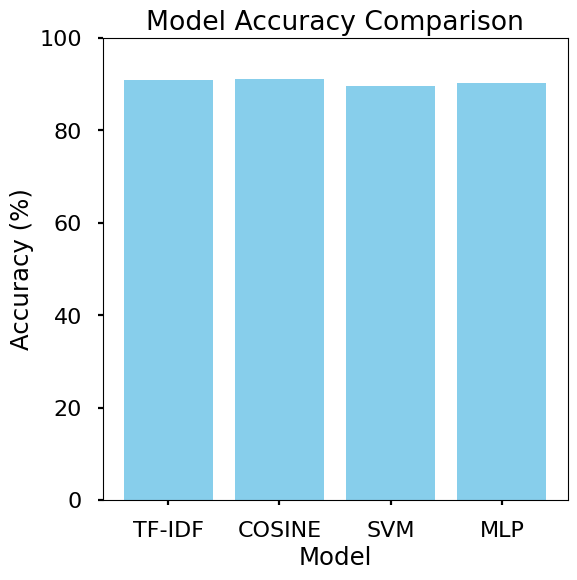

In [ ]:
import matplotlib.pyplot as plt

# Lists containing model names and their corresponding accuracies
model_list = ["TF-IDF", "COSINE", "SVM", "MLP"]
accuracy_list = [acc_rf, acc_knn, acc_svm, acc_mlp]

# Plotting the bar graph
plt.figure(figsize=(6, 6))
plt.bar(model_list, accuracy_list, color='skyblue')
plt.xlabel('Model')
plt.ylabel('Accuracy (%)')
plt.title('Model Accuracy Comparison')
plt.ylim(0, 100)  # Set the y-axis limit from 0 to 100 for percentage accuracy
plt.show()
